importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

loading data

In [2]:
df = pd.read_csv("data.csv")
df.head()

,timestamp,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,1751310000,3,138.79,0.0,2.87,50.40,0.89,14.70,72.14,23.77
1,1751313600,3,135.05,0.0,2.62,51.07,0.79,15.87,78.71,24.04
2,1751317200,3,133.58,0.0,2.36,51.72,0.71,17.26,86.18,24.06
3,1751320800,3,134.32,0.0,2.14,52.74,0.65,18.96,94.14,23.75
4,1751324400,4,138.66,0.0,1.97,55.50,0.64,21.16,101.75,23.67


In [3]:
df.shape

(4969, 10)

In [4]:
df.isnull().sum()

timestamp    0
aqi          0
co           0
no           0
no2          0
o3           0
so2          0
pm2_5        0
pm10         0
nh3          0
dtype: int64

In [5]:
df.describe()

,timestamp,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,4.969000e+03,4969.000000,4969.000000,4969.000000,4969.000000,4969.000000,4969.000000,4969.000000,4969.000000,4969.000000
mean,1.760262e+09,4.064198,582.427903,0.235524,7.940789,72.460829,3.206353,97.684834,170.747251,8.495351
std,5.179167e+06,0.935148,436.070033,0.566107,5.344972,34.847177,3.310785,95.551476,124.436760,9.642246
min,1.751310e+09,2.000000,109.880000,0.000000,0.330000,4.300000,0.220000,8.310000,14.580000,0.000000
25%,1.755781e+09,3.000000,259.990000,0.000000,3.340000,46.190000,1.040000,29.560000,79.610000,2.030000
50%,1.760252e+09,4.000000,461.950000,0.010000,7.100000,64.100000,1.980000,63.160000,122.180000,4.850000
75%,1.764724e+09,5.000000,759.240000,0.200000,11.590000,93.200000,4.250000,127.920000,242.420000,11.210000
max,1.769281e+09,5.000000,2506.380000,8.480000,24.710000,194.600000,26.290000,522.070000,575.680000,59.710000


# Feature Engineering

Time Based Columns

In [6]:

# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Time components
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['date'] = df['datetime'].dt.date
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday


Polution source indicators

Each one represents the estimated contribution of a specific pollution source rather than raw pollutant levels.

In [7]:
# Indicators of different pollution sources
df['vehicle_pollution_idx'] = df['co'] * 0.5 + df['no2'] * 0.3 + df['pm2_5'] * 0.2
df['industrial_pollution_idx'] = df['so2'] * 0.4 + df['pm10'] * 0.4 + df['no2'] * 0.2
df['agricultural_pollution_idx'] = df['nh3'] * 0.6 + df['pm10'] * 0.4

Seasonal classification

It is useful for trend prediction, regime classification, and explanation of why AQI changes across the year.

In [8]:
# Seasonal classification based on month
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df['season'] = df['month'].apply(get_season)

Time Period classification

The time_of_day column compresses 24 sparse hour values into 4 meaningful regimes (Morning, Afternoon, Evening, Night). This reduces noise, improves generalization, and helps simpler models capture diurnal effects more easily than raw hours.

In [9]:
def classify_time(hour):
    if 5 <= hour < 12: return 'Morning'
    elif 12 <= hour < 17: return 'Afternoon'
    elif 17 <= hour < 21: return 'Evening'
    elif 21 <= hour < 24 or 0 <= hour < 5: return 'Night'

df['time_of_day'] = df['hour'].apply(classify_time)

Pollution ratios and indices

These ratios and indices **encode chemical relationships and pollution sources**, not just raw magnitudes. Models learn patterns faster from ratios because they reflect **relative dominance**, which stays stable even when absolute levels change.

`pm_ratio` indicates **fine vs coarse particle dominance**. High values usually mean combustion-related pollution, which strongly affects AQI and health impact.

`no_to_no2_ratio` reflects **fresh traffic emissions** versus aged air. This helps distinguish rush-hour effects from background pollution.

`o3_to_no2_ratio` captures **photochemical activity**. It is crucial for understanding daytime ozone formation and diurnal AQI behavior.

`total_particulates` summarizes **overall particulate load**, reducing dimensionality while preserving impact.

`gas_pollutants_sum` captures **combined gaseous pollution stress**, which often correlates better with AQI than individual gases.

In [10]:
# Key ratios used in environmental studies
df['pm_ratio'] = df['pm2_5'] / df['pm10']  
df['no_to_no2_ratio'] = df['no'] / (df['no2'] + 0.001)  
df['o3_to_no2_ratio'] = df['o3'] / (df['no2'] + 0.001)  
df['total_particulates'] = df['pm2_5'] + df['pm10'] + df['nh3']
df['gas_pollutants_sum'] = df['co'] + df['no'] + df['no2'] + df['so2']

Change/Difference columns

The change columns (`aqi_change`, `pm25_change`) capture **dynamics**, not levels. AQI forecasting depends more on *how fast pollution is rising or falling* than on the absolute value at a single hour.

`aqi_trend` converts numeric change into a **directional signal**. This is useful for classification, alerting systems, and explainability, even if you later drop it for pure regression models.

The rolling averages (`aqi_6hr_avg`, `pm25_24hr_avg`) represent **short-term and daily persistence** of pollution. AQI standards and health guidelines are based on sustained exposure, so these features are highly predictive and domain-aligned.

Overall, these are **core time-series features** for AQI modeling.


In [11]:
# Rate of change between readings
df['aqi_change'] = df['aqi'].diff()  
df['pm25_change'] = df['pm2_5'].diff()
df['aqi_trend'] = df['aqi_change'].apply(lambda x: 'Increasing' if x > 0 else 'Decreasing' if x < 0 else 'Stable')

# Rolling averages (e.g., 6-hour moving average)
df['aqi_6hr_avg'] = df['aqi'].rolling(window=6, min_periods=1).mean()
df['pm25_24hr_avg'] = df['pm2_5'].rolling(window=24, min_periods=1).mean()

# Visualizations

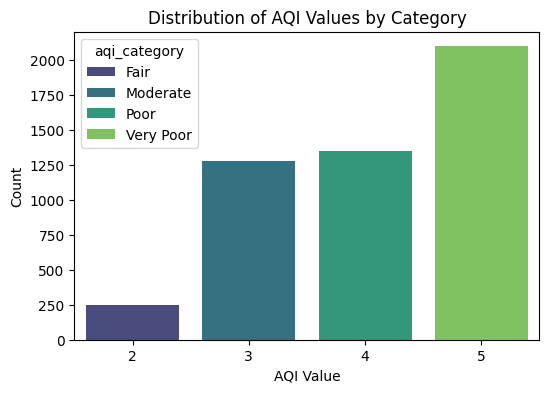

In [13]:
# AQI category mapping (OpenWeather scale)
def aqi_category(aqi):
    if aqi == 1:
        return "Good"
    elif aqi == 2:
        return "Fair"
    elif aqi == 3:
        return "Moderate"
    elif aqi == 4:
        return "Poor"
    else:
        return "Very Poor"

# Create AQI category column
df["aqi_category"] = df["aqi"].apply(aqi_category)

# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(x="aqi", data=df, hue="aqi_category", palette="viridis")

plt.title("Distribution of AQI Values by Category")
plt.xlabel("AQI Value")
plt.ylabel("Count")
plt.show()


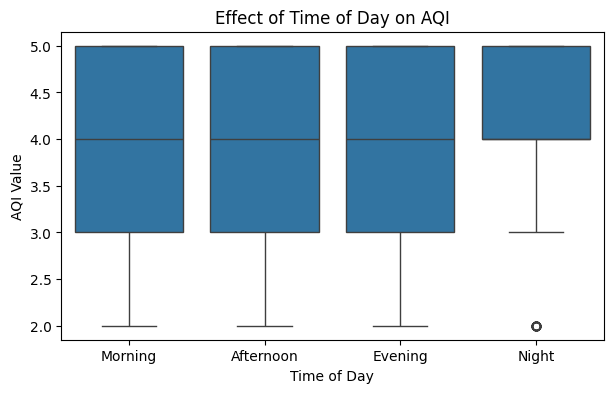

In [14]:
# Box plot to show AQI distribution by time of day
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="time_of_day",
    y="aqi",
    data=df,
    order=["Morning", "Afternoon", "Evening", "Night"]
)

plt.title("Effect of Time of Day on AQI")
plt.xlabel("Time of Day")
plt.ylabel("AQI Value")
plt.show()


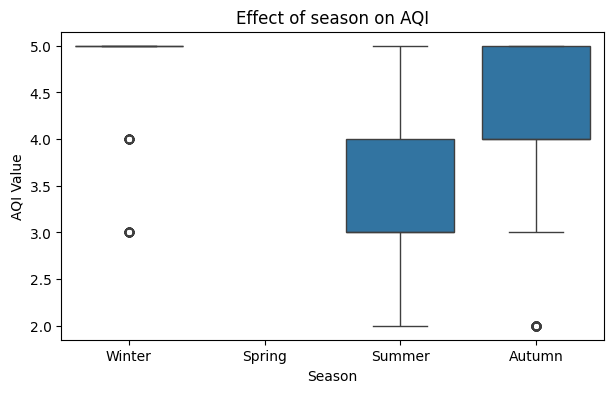

In [15]:
# Box plot to show AQI distribution by time of day
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="season",
    y="aqi",
    data=df,
    order = ["Winter", "Spring", "Summer", "Autumn"]
    
)

plt.title("Effect of season on AQI")
plt.xlabel("Season")
plt.ylabel("AQI Value")
plt.show()


### Time Series Plot

### Why this?
This visualization captures the pollution signature of severe AQI events in one view, making pollutant dominance patterns clear and easy to compare with cleaner periods.

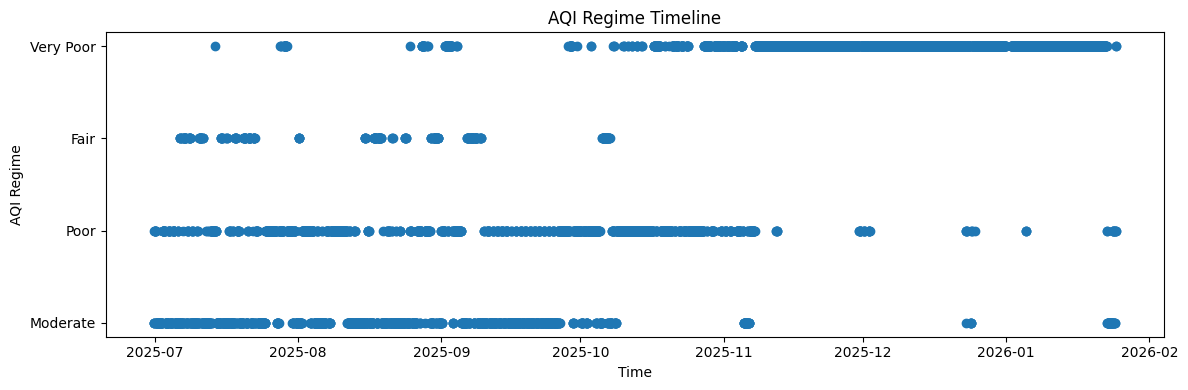

In [16]:
# Convert unix timestamp to datetime
plt.figure(figsize=(12, 4))

plt.scatter(df['datetime'], df['aqi_category'])

plt.xlabel("Time")
plt.ylabel("AQI Regime")
plt.title("AQI Regime Timeline")

plt.tight_layout()
plt.show()


### Why this?
It visualizes pollution regimes over time, not just numbers. Evaluators see pattern shifts, regime persistence, and pollution phases, which directly supports forecasting and feature engineering.

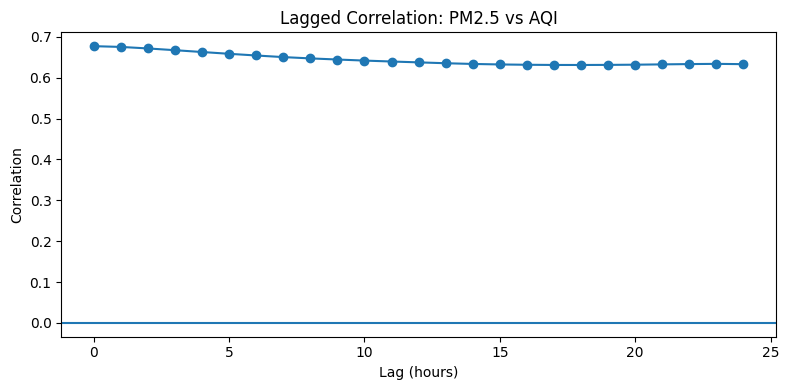

In [18]:

df = df.sort_values("datetime")

# Compute lagged correlations
max_lag = 24  # hours
lags = range(0, max_lag + 1)
correlations = []

for lag in lags:
    corr = df["aqi"].corr(df["pm2_5"].shift(lag))
    correlations.append(corr)

# Plot lagged correlation
plt.figure(figsize=(8, 4))
plt.plot(lags, correlations, marker="o")
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.title("Lagged Correlation: PM2.5 vs AQI")
plt.axhline(0)

plt.tight_layout()
plt.show()


### How to interpret
If correlation peaks at a positive lag, PM2.5 rises before AQI worsens. This directly justifies using lag features in your prediction model.

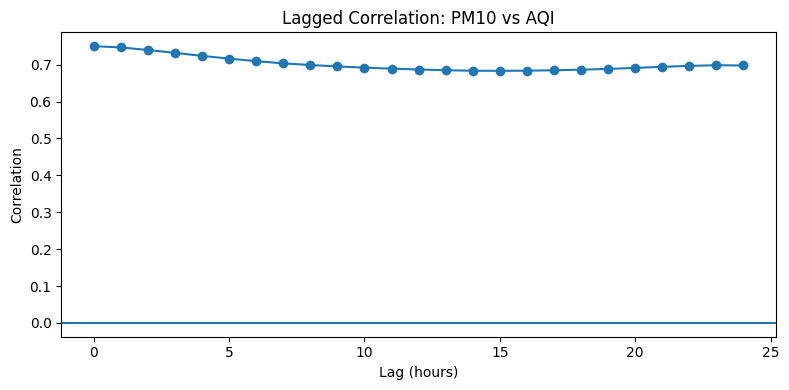

In [19]:


df = df.sort_values("datetime")

# Compute lagged correlations
max_lag = 24  # hours
lags = range(0, max_lag + 1)
correlations = []

for lag in lags:
    corr = df["aqi"].corr(df["pm10"].shift(lag))
    correlations.append(corr)

# Plot lagged correlation
plt.figure(figsize=(8, 4))
plt.plot(lags, correlations, marker="o")
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.title("Lagged Correlation: PM10 vs AQI")
plt.axhline(0)

plt.tight_layout()
plt.show()


**2. Pollutants Correlation Matrix**

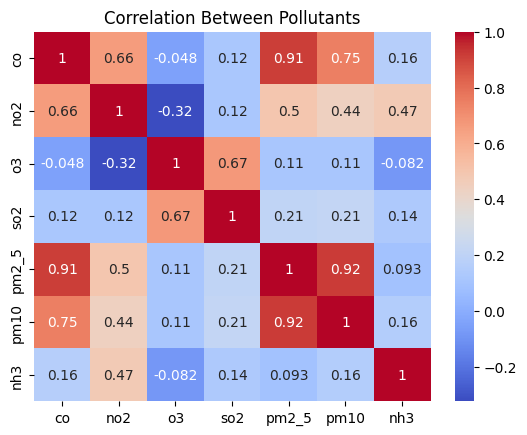

In [20]:
# Shows which pollutants rise/fall together

pollutants = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
corr_matrix = df[pollutants].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutants')
plt.show()

#### Pollutant Comparison Radar Chart
   
   Pollution Fingerprint During High AQI Periods

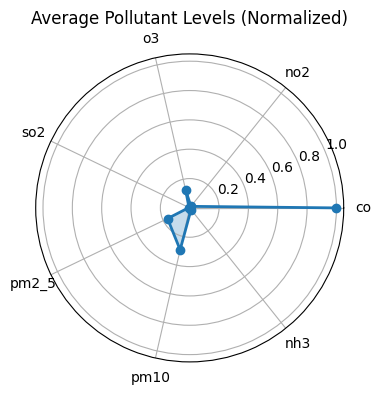

In [21]:
# Normalize pollutant values for comparison
pollutants = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
avg_values = df[pollutants].mean().values
normalized = avg_values / avg_values.max()  # Scale to 0-1

angles = np.linspace(0, 2*np.pi, len(pollutants), endpoint=False)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, normalized, 'o-', linewidth=2)
ax.fill(angles, normalized, alpha=0.25)
ax.set_xticks(angles)
ax.set_xticklabels(pollutants)
plt.title('Average Pollutant Levels (Normalized)')
plt.show()

Hourly/Daily Patterns

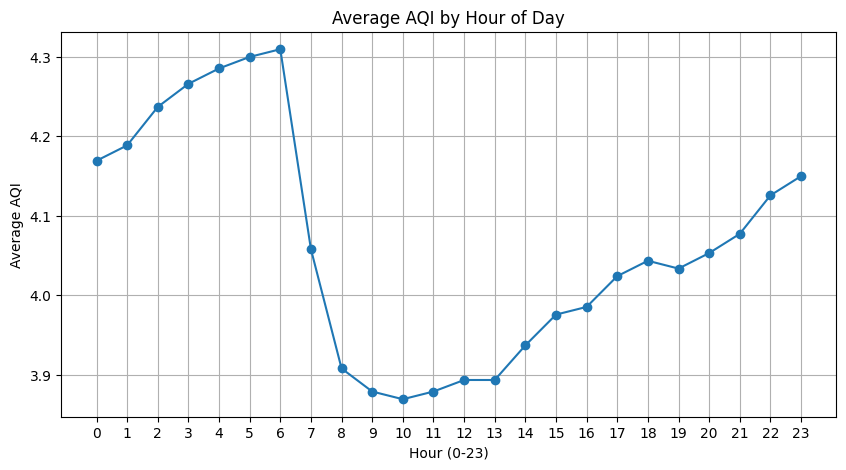

In [22]:
# Find patterns in pollution by time of day
hourly_avg = df.groupby('hour')['aqi'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('Average AQI by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Average AQI')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

Pollutant Contribution Pie Chart

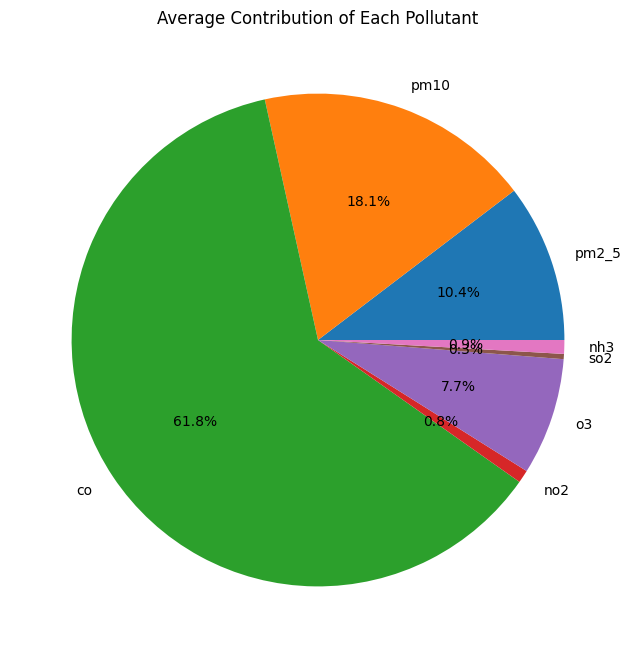

In [23]:
# Which pollutant contributes most to poor air quality?
# Normalize to show relative contribution
pollutants = ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2', 'nh3']
avg_levels = df[pollutants].mean()

plt.figure(figsize=(10, 8))
plt.pie(avg_levels, labels=pollutants, autopct='%1.1f%%')
plt.title('Average Contribution of Each Pollutant')
plt.show()

Scatter Plot with AQI vs PM2.5

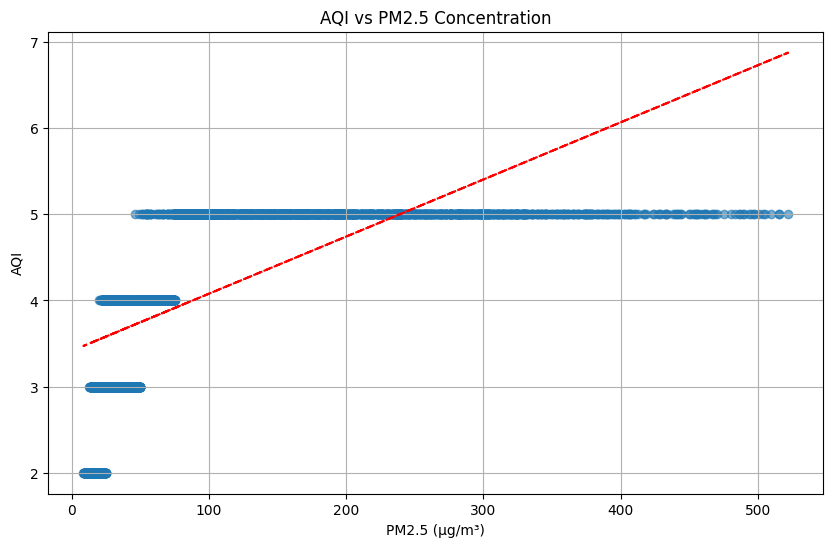

In [24]:
# Most important relationship (PM2.5 is key health indicator)
plt.figure(figsize=(10, 6))
plt.scatter(df['pm2_5'], df['aqi'], alpha=0.6)
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('AQI')
plt.title('AQI vs PM2.5 Concentration')
plt.grid(True)

# Add trend line
z = np.polyfit(df['pm2_5'], df['aqi'], 1)
p = np.poly1d(z)
plt.plot(df['pm2_5'], p(df['pm2_5']), "r--")
plt.show()

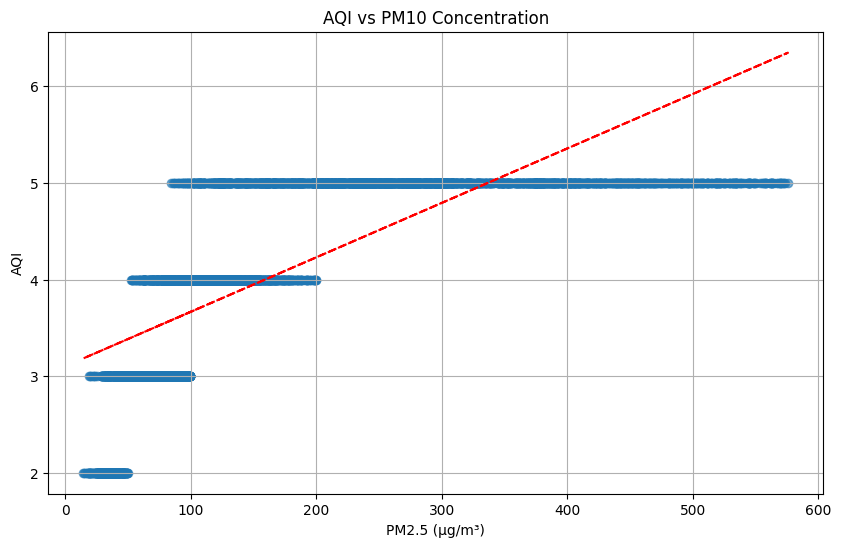

In [25]:
# Most important relationship (PM2.5 is key health indicator)
plt.figure(figsize=(10, 6))
plt.scatter(df['pm10'], df['aqi'], alpha=0.6)
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('AQI')
plt.title('AQI vs PM10 Concentration')
plt.grid(True)

# Add trend line
z = np.polyfit(df['pm10'], df['aqi'], 1)
p = np.poly1d(z)
plt.plot(df['pm10'], p(df['pm10']), "r--")
plt.show()

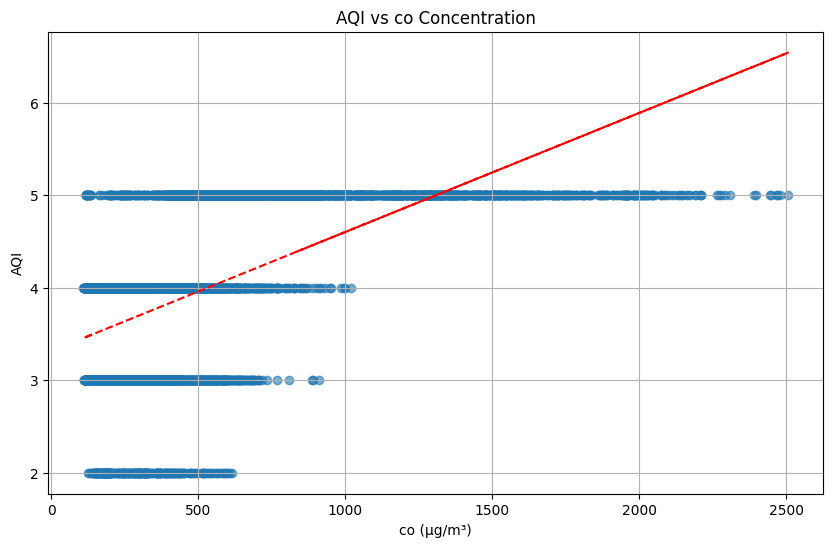

In [26]:
# Most important relationship (PM2.5 is key health indicator)
plt.figure(figsize=(10, 6))
plt.scatter(df['co'], df['aqi'], alpha=0.6)
plt.xlabel('co (µg/m³)')
plt.ylabel('AQI')
plt.title('AQI vs co Concentration')
plt.grid(True)

# Add trend line
z = np.polyfit(df['co'], df['aqi'], 1)
p = np.poly1d(z)
plt.plot(df['co'], p(df['co']), "r--")
plt.show()

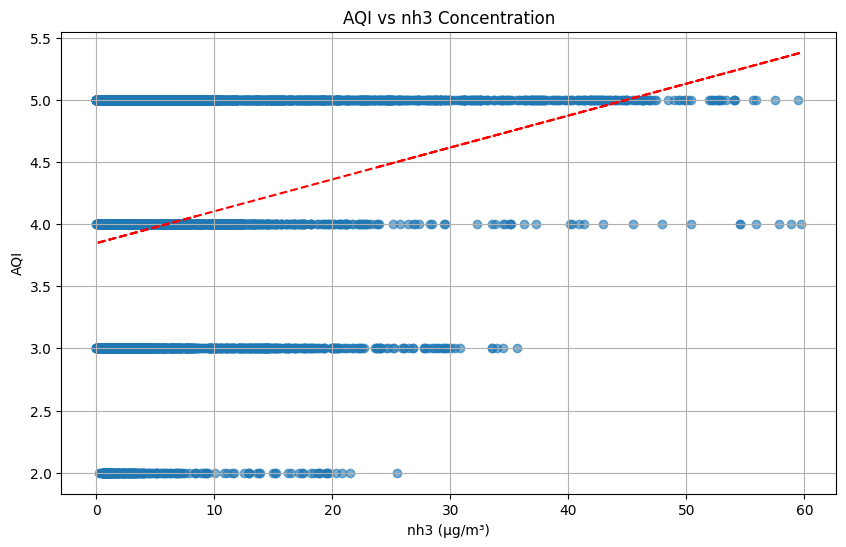

In [27]:
# Most important relationship (PM2.5 is key health indicator)
plt.figure(figsize=(10, 6))
plt.scatter(df['nh3'], df['aqi'], alpha=0.6)
plt.xlabel('nh3 (µg/m³)')
plt.ylabel('AQI')
plt.title('AQI vs nh3 Concentration')
plt.grid(True)

# Add trend line
z = np.polyfit(df['nh3'], df['aqi'], 1)
p = np.poly1d(z)
plt.plot(df['nh3'], p(df['nh3']), "r--")
plt.show()

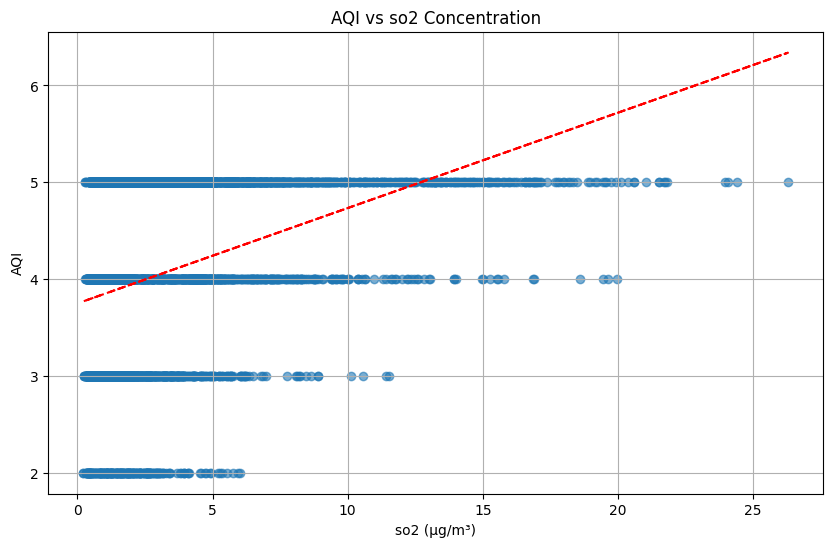

In [28]:
# Most important relationship (PM2.5 is key health indicator)
plt.figure(figsize=(10, 6))
plt.scatter(df['so2'], df['aqi'], alpha=0.6)
plt.xlabel('so2 (µg/m³)')
plt.ylabel('AQI')
plt.title('AQI vs so2 Concentration')
plt.grid(True)

# Add trend line
z = np.polyfit(df['so2'], df['aqi'], 1)
p = np.poly1d(z)
plt.plot(df['so2'], p(df['so2']), "r--")
plt.show()

In [29]:
df.shape

(4969, 32)

In [30]:
# store the cleaned data 
df.to_csv("cleaned_data.csv", index = False)

### Final Features Selection for Models

In [2]:
df = pd.read_csv("cleaned_data.csv")

### Encoding categorical features

In [3]:
# Season encoding
season_map = {
    "Spring": 0,
    "Summer": 1,
    "Autumn": 2,
    "Winter": 3
}

df["seasons"] = df["season"].map(season_map)

# Time of day encoding
time_map = {
    "Morning": 0,
    "Afternoon": 1,
    "Evening": 2,
    "Night": 3
}

df["timeof_day"] = df["time_of_day"].map(time_map)

# Drop original categorical columns
df.drop(columns=["season", "time_of_day"], inplace=True)


### creating lag features

In [4]:

df = df.sort_values("timestamp").reset_index(drop=True)

lags = [1, 2, 3, 6, 12, 24]
for lag in lags:
    df[f"aqi_lag_{lag}"] = df["aqi"].shift(lag)

df["aqi_24hr_avg"] = df["aqi"].rolling(24).mean()

df = df.dropna().reset_index(drop=True)

In [5]:
df.shape

(4945, 39)

In [6]:
df.columns

Index(['timestamp', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10',
       'nh3', 'datetime', 'hour', 'month', 'year', 'date', 'day_of_week',
       'vehicle_pollution_idx', 'industrial_pollution_idx',
       'agricultural_pollution_idx', 'pm_ratio', 'no_to_no2_ratio',
       'o3_to_no2_ratio', 'total_particulates', 'gas_pollutants_sum',
       'aqi_change', 'pm25_change', 'aqi_trend', 'aqi_6hr_avg',
       'pm25_24hr_avg', 'aqi_category', 'seasons', 'timeof_day', 'aqi_lag_1',
       'aqi_lag_2', 'aqi_lag_3', 'aqi_lag_6', 'aqi_lag_12', 'aqi_lag_24',
       'aqi_24hr_avg'],
      dtype='object')

In [ ]:
df2 = df[["timestamp","seasons", "hour", "month", "year", "day_of_week","timeof_day","aqi_lag_1", "aqi_lag_2", "aqi_lag_3", "aqi_lag_6", "aqi_lag_12", "aqi_lag_24", "aqi_24hr_avg", "aqi"]]

In [12]:
df2.shape

(4945, 14)

In [17]:
df2['aqi_24hr_avg'] = df2['aqi_24hr_avg'].round(2)

C:\Users\Asad\AppData\Local\Temp\ipykernel_10856\120143395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['aqi_24hr_avg'] = df2['aqi_24hr_avg'].round(2)


In [18]:
# store the cleaned data 
df2.to_csv("final_features.csv", index = False)